# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
import seaborn as sns

# Part 2

## Reward class

In [2]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [3]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]
    
    def expected_rewards(self):
        self.act0_reward = np.dot((np.array([4, 5, 5.1]) - 5 ), np.array([0.2, 0.2, 0.6]))
        self.act1_reward = np.dot((np.array([5, 10, 20, 20.75]) - 20 ), np.array([0.5, 0.3, 0.1, 0.1]))
        self.act2_reward = np.dot((np.array([10, 20, 50, 100, 105]) - 100 ), np.array([0.5, 0.3, 0.1, 0.05, 0.05]))
        return [self.act0_reward, self.act1_reward, self.act2_reward]
        

In [4]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]
    
    def expected_rewards(self):
        self.act0_reward = np.dot(( np.array([4, 5, 5.1]) - 5 ), np.array([0.05, 0.3, 0.65]))
        self.act1_reward = np.dot(( np.array([5, 10, 20, 20.75]) - 20 ), np.array([0.1, 0.1, 0.3, 0.5]))
        self.act2_reward = np.dot(( np.array([20, 50, 80, 100, 105]) - 100 ), np.array([0.1, 0.1, 0.2, 0.3, 0.3]))
        return [self.act0_reward, self.act1_reward, self.act2_reward]

In [5]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]
    
    def expected_rewards(self):
        self.act0_reward = np.dot(( np.array([0, 2.5, 5.1]) - 5 ), np.array([0.8, 0.1, 0.1]) )
        self.act1_reward = np.dot(( np.array([5, 10, 20, 20.75]) - 20 ), np.array([0.05, 0.05, 0.3, 0.6]) )
        self.act2_reward = np.dot(( np.array([20, 50, 80, 100, 105]) - 100 ), np.array([0.02, 0.03, 0.05, 0.2, 0.7]) )
        return [self.act0_reward, self.act1_reward, self.act2_reward]
                                                                     

## Environment

In [6]:
class Environment:
    def __init__(self, reward, id=None):
        self.reward = reward
        
    def calc_reward(self, action):
        return self.reward().get_reward(action)[1]

    def get_available_actions(self):
        return np.arange(3)
    

# Part 3

In [7]:
class Agent(ABC):
    def __init__(self, env, alpha=0, beta=1, gamma=1, _id=None):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.env = Environment(env)                    # Input enviroments ( student, self-employed, government-staff )
        self.actions = np.arange(3)                    # Arms
        self.n = 1                                     # Step count
        self.n_a = np.ones(3)                          # Step count for each arm
        self.n_a_t = [[], [], []]                      # chosen action en each trial
        self.Q_mean_total = 0                          # Total mean reward
        self.utils = []                                # Total utiltiy
        self.regrets = []                              # Calculated regrets
        self.Q_mean_per_action = np.zeros(3)           # Mean reward per action
        self.utils_per_action = [[], [], []]           # Utiltiy per action

    @abstractmethod
    def choose_action(self):
        pass
    
    def calculate_utility(self, reward):
        return self.beta * reward ** self.gamma + self.alpha
    
    def take_action(self, action):
        return self.env.calc_reward(action)
    
    def update_value(self, action, util):
        for act in range(3):
            if act == action:
                self.n_a_t[act].append(1)
            else:
                self.n_a_t[act].append(0)
        self.Q_mean_total += ( util - self.Q_mean_total ) / self.n
        self.Q_mean_per_action[action] += ( util - self.Q_mean_per_action[action] ) / self.n_a[action]
        self.n += 1
        self.n_a[action] += 1
    
    @abstractmethod
    def step(self, best_reward, trial):
        pass

    def reset(self):
        self.n = 1                                     # Step count
        self.n_a = np.ones(3)                          # Step count for each arm
        self.n_a_t = [[], [], []]                      # chosen action en each trial
        self.Q_mean_total = 0                          # Total mean reward
        self.utils = []                                # Total utiltiy
        self.regrets = []                              # Calculated regrets
        self.Q_mean_per_action = np.zeros(3)           # Mean reward per action
        self.utils_per_action = [[], [], []]           # Utiltiy per action
    
    def get_rewards(self):
        return np.cumsum(self.utils) / np.arange(1, len(self.utils)+1)
    
    def get_regrets(self):
        return self.regrets
        

## Epsilon Greedy

In [8]:
class Epsilon_Greedy(Agent):
    def __init__(self, eps, env):
        super(Epsilon_Greedy, self).__init__(env)
        self.eps = eps    # epsilon
        
    def choose_action(self):
        p = np.random.random()
        if p < self.eps:
            self.a = np.random.choice(self.actions)
        else:
            self.a = np.argmax(self.Q_mean_per_action)
        return self.a
    
    def step(self, best_reward, trial):
        self.reset()
        for step in range(trial):
            act = self.choose_action()
            rwrd = self.take_action(act)
            util = self.calculate_utility(rwrd)
            self.update_value(act, util)
            self.utils.append(util)
            self.utils_per_action[act].append(util)
            self.regrets.append(self.n*best_reward - np.sum(self.utils))


## Gradient Based

In [9]:
class Gradient_Based(Agent):
    def __init__(self, lr, env):
        super(Gradient_Based, self).__init__(env)
        self.lr = lr                 # learning rate
        self.H = np.zeros(3)         # Initialize preferences

    def choose_action(self):
        exp = np.exp(self.H - np.max(self.H))
        self.p_per_action = exp / np.sum(exp, axis=0)                   # Update probabilities with softmax
        self.a = np.random.choice(self.actions, p=self.p_per_action)    # choose highest preference action
        return self.a
    
    def update_preferences(self, action, util):
        for a in range(3):
            if a == action:
                self.H[a] += self.lr * (util - self.Q_mean_total) * (1 - self.p_per_action[a])
            else:
                self.H[a] -= self.lr * (util - self.Q_mean_total) * self.p_per_action[a]
                
    def step(self, best_reward, trial):
        self.reset()
        self.H = np.zeros(3)
        for step in range(trial):
            act = self.choose_action()
            rwrd = self.take_action(act)
            util = self.calculate_utility(rwrd)
            self.update_value(act, util)
            self.utils.append(util)
            self.utils_per_action[act].append(util)
            self.regrets.append(self.n*best_reward - np.sum(self.utils))
            self.update_preferences(act, util)


## Upper Confidence Bound

In [10]:
class UCB(Agent):
    def __init__(self, c, env):
        super(UCB, self).__init__(env)
        self.c = c   # exploration factor
        
    def choose_action(self):
        self.a = np.argmax(self.Q_mean_per_action + self.c * np.sqrt(np.log(self.n) / self.n_a))
        return self.a
    
    def step(self, best_reward, trial):
        self.reset()
        for step in range(trial):
            act = self.choose_action()
            rwrd = self.take_action(act)
            util = self.calculate_utility(rwrd)
            self.update_value(act, util)
            self.utils.append(util)
            self.utils_per_action[act].append(util)
            self.regrets.append(self.n*best_reward - np.sum(self.utils))


## Run Func.

In [11]:
def Run(run, trial, enviroment, eps, lr, c):
    rewards = np.zeros([3, run, trial])
    regrets1 = np.zeros([3, run, trial])
    regrets2 = np.zeros([3, trial])
    Ti = np.zeros([run, 3, trial])
    best_reward = max(enviroment().expected_rewards())
    delta = np.expand_dims(best_reward - np.array(enviroment().expected_rewards()), 1)
    
    for p, policy in enumerate([Epsilon_Greedy(eps ,enviroment), Gradient_Based(lr ,enviroment), UCB(c ,enviroment)]):
        for r in range(run):
            Pi = policy
            Pi.step(best_reward, trial)
            rewards[p,r,:] = Pi.get_rewards()
            regrets1[p,r,:] = Pi.get_regrets()
            Ti[r,:,:] = np.cumsum(np.array(Pi.n_a_t), axis=1)
        regrets2[p,:] = np.sum(np.mean(Ti, axis=0) * delta, 0)
    
    rewards = np.mean(rewards, 1)
    regrets1 = np.mean(regrets1, 1)
    return rewards, regrets2, regrets1

# Q4 Plots

In [12]:
def plots(env_str, rewards, regrets, best_reward):
    plt.subplots(2,1, figsize=(13,10), sharex=True)
    plt.subplot(211)
    plt.plot(rewards[0,:], label='Epsilon Greedy')
    plt.plot(rewards[1,:], label='Gradient Based')
    plt.plot(rewards[2,:], label='Upper Confidence Bound')
    plt.axhline(y=best_reward, alpha=0.5, color='r', linewidth=2, linestyle='--', label='Best Reward')
    plt.ylabel('Reward', fontsize=20)
    plt.legend(title='Rewards', fontsize=15, title_fontsize=30, loc=4)
    sns.despine()
    plt.grid()

    plt.subplot(212)
    plt.plot(regrets[0,:], label='Epsilon Greedy')
    plt.plot(regrets[1,:], label='Gradient Based')
    plt.plot(regrets[2,:], label='Upper Confidence Bound')
    plt.xlabel('Trials', fontsize=20)
    plt.ylabel('Regret', fontsize=20)
    plt.legend(title='Regrets', fontsize=15, title_fontsize=30, loc=2)
    sns.despine()
    plt.grid()
    
    plt.suptitle(env_str+' Rewards & Regrets', y=0.99, fontsize=35)
    plt.tight_layout(pad=1)

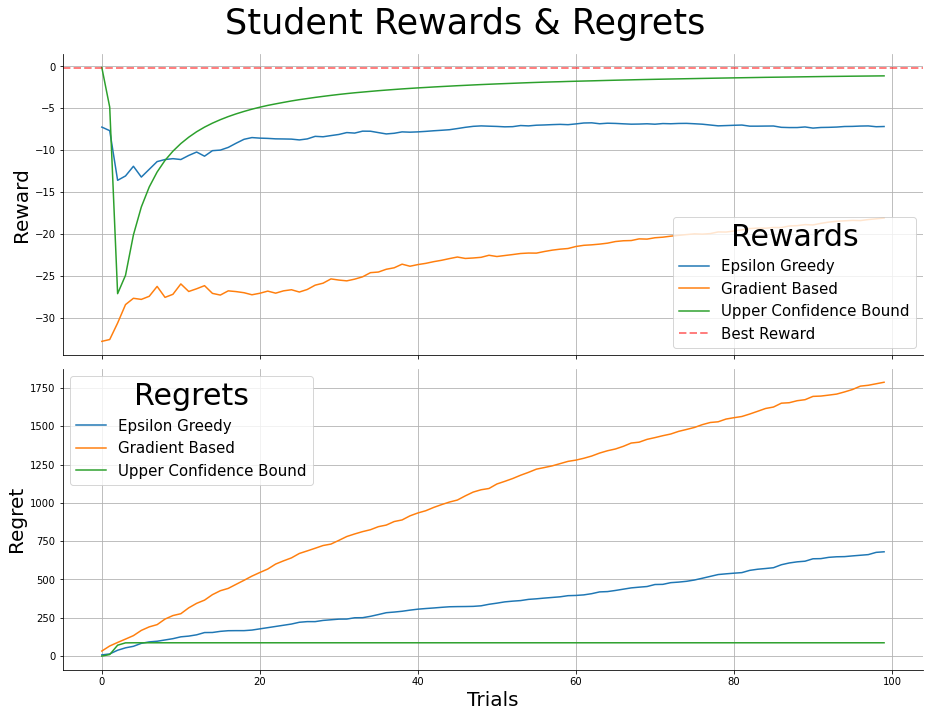

In [13]:
rewards, regrets, _ = Run(run=20, trial=100, enviroment=Student, eps=0.2, lr=0.001, c=2)
plots('Student', rewards, regrets, best_reward=max(Student().expected_rewards()))

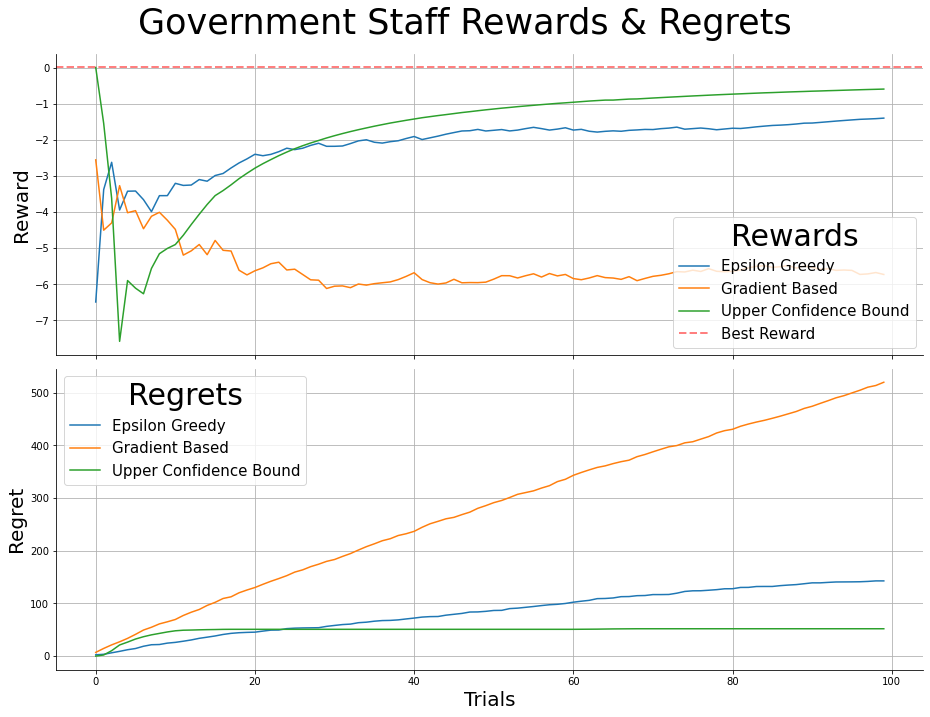

In [14]:
rewards, regrets, _ = Run(run=20, trial=100, enviroment=GovStaff, eps=0.2, lr=0.001, c=2)
plots('Government Staff', rewards, regrets, best_reward=max(GovStaff().expected_rewards()))

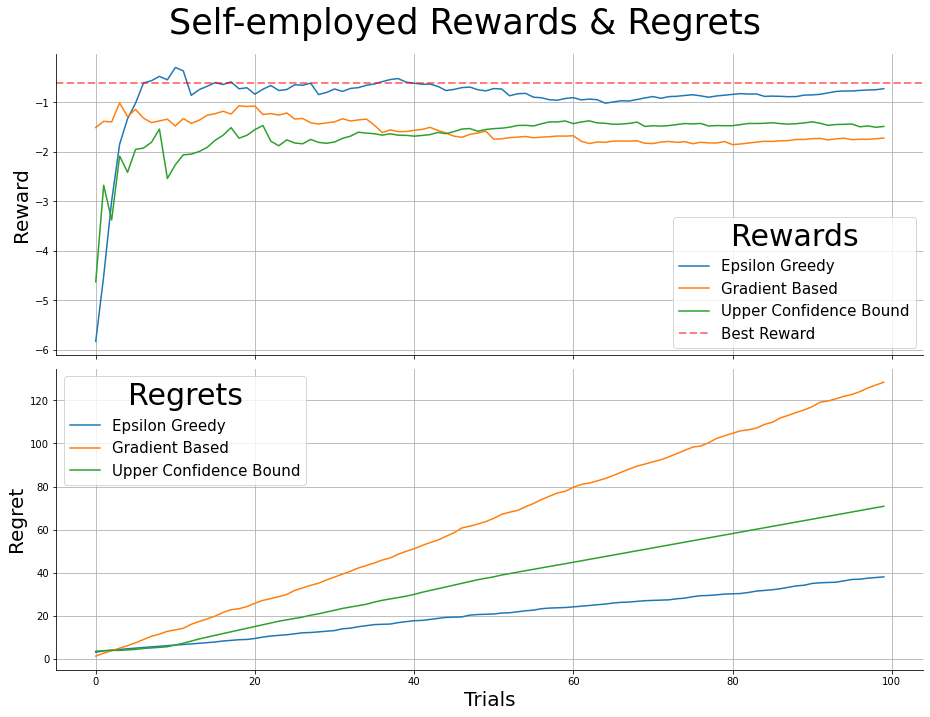

In [15]:
rewards, regrets, _ = Run(run=20, trial=100, enviroment=SelfEmp, eps=0.2, lr=0.001, c=2)
plots('Self-employed', rewards, regrets, best_reward=max(SelfEmp().expected_rewards()))

# Q5 Plots

In [16]:
def Gradient_Based_plots(run, trial, enviroment, env_str, LRs):
    rewards = np.zeros([4, run, trial])
    regrets = np.zeros([4, trial])
    Ti = np.zeros([run, 3, trial])
    best_reward = max(enviroment().expected_rewards())
    delta = np.expand_dims(best_reward - np.array(enviroment().expected_rewards()), 1)
    
    for i, lr in enumerate(LRs):
        for r in range(run):
            Pi = Gradient_Based(lr ,enviroment)
            Pi.step(best_reward, trial)
            rewards[i,r,:] = Pi.get_rewards()
            Ti[r,:,:] = np.cumsum(np.array(Pi.n_a_t), axis=1)
        regrets[i,:] = np.sum(np.mean(Ti, axis=0) * delta, 0)
    rewards = np.mean(rewards, 1)
    
    plt.subplots(2,1, figsize=(13,10), sharex=True)
    plt.subplot(211)
    plt.plot(rewards[0], label='Learning rate = '+str(LRs[0]))
    plt.plot(rewards[1], label='Learning rate = '+str(LRs[1]))
    plt.plot(rewards[2], label='Learning rate = '+str(LRs[2]))
    plt.plot(rewards[3], label='Learning rate = '+str(LRs[3]))
    plt.axhline(y=best_reward, alpha=0.5, color='r', linewidth=2, linestyle='--', label='Best Reward')
    plt.ylabel('Reward', fontsize=20)
    plt.legend(title='Rewards', fontsize=15, title_fontsize=30, loc=4)
    sns.despine()
    plt.grid()

    plt.subplot(212)
    plt.plot(regrets[0], label='Learning rate = '+str(LRs[0]))
    plt.plot(regrets[1], label='Learning rate = '+str(LRs[1]))
    plt.plot(regrets[2], label='Learning rate = '+str(LRs[2]))
    plt.plot(regrets[3], label='Learning rate = '+str(LRs[3]))
    plt.xlabel('Trials', fontsize=20)
    plt.ylabel('Regret', fontsize=20)
    plt.legend(title='Regrets', fontsize=15, title_fontsize=30, loc=2)
    sns.despine()
    plt.grid()

    plt.xticks(ticks=np.arange(0,trial), labels=np.arange(1,trial+1))
    plt.suptitle('Gradient-Based Algo for '+env_str, y=0.99, fontsize=35)
    plt.tight_layout(pad=1)
    

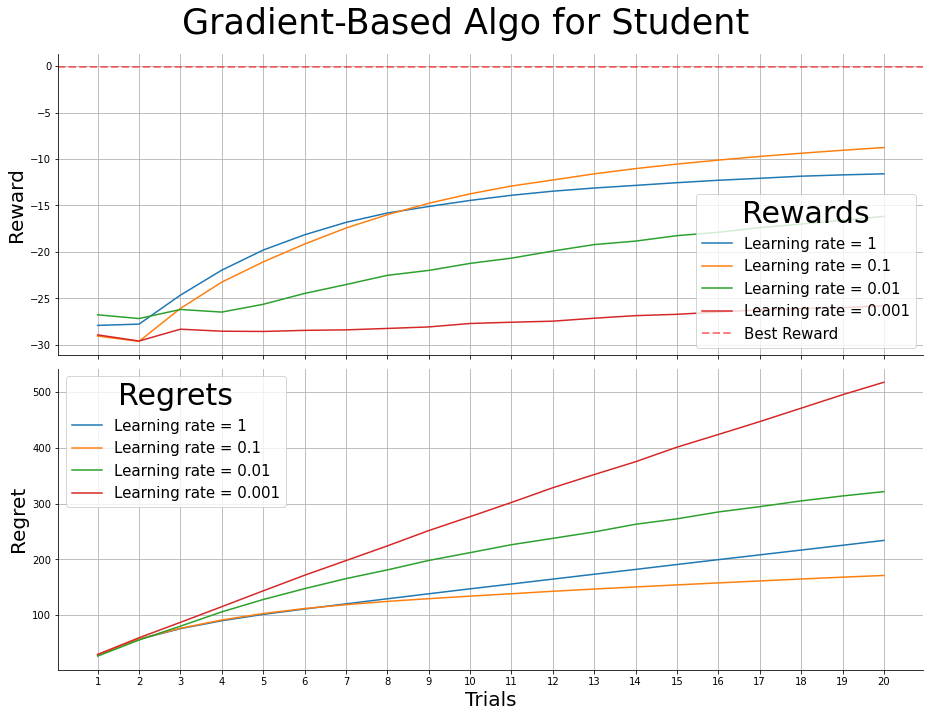

In [17]:
Gradient_Based_plots(run=500, trial=20, enviroment=Student, env_str='Student', LRs=[1, 0.1, 0.01, 0.001])

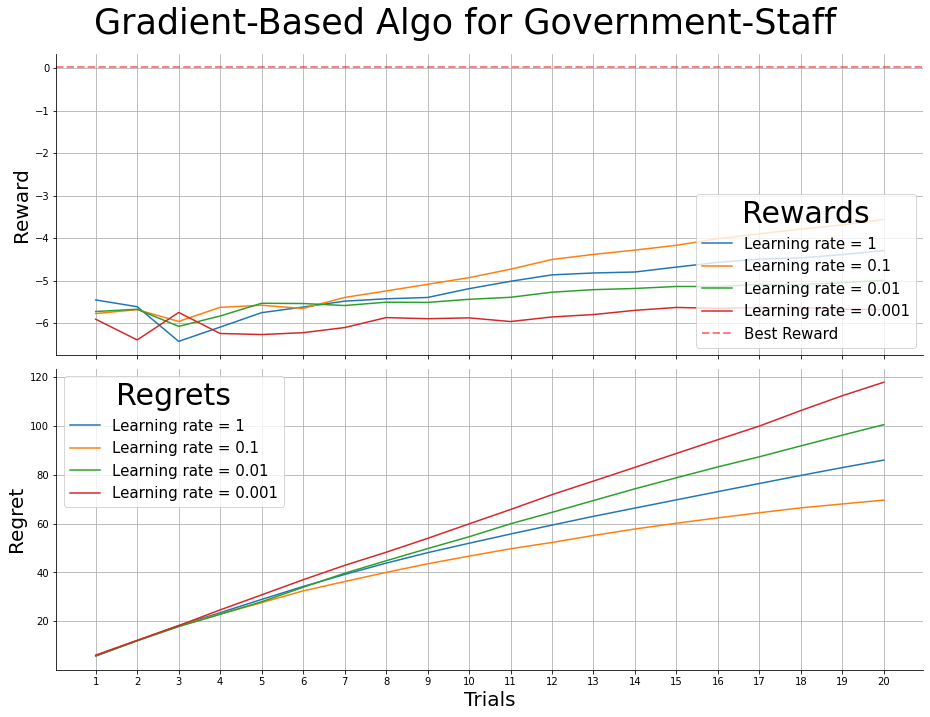

In [18]:
Gradient_Based_plots(run=500, trial=20, enviroment=GovStaff, env_str='Government-Staff', LRs=[1, 0.1, 0.01, 0.001])

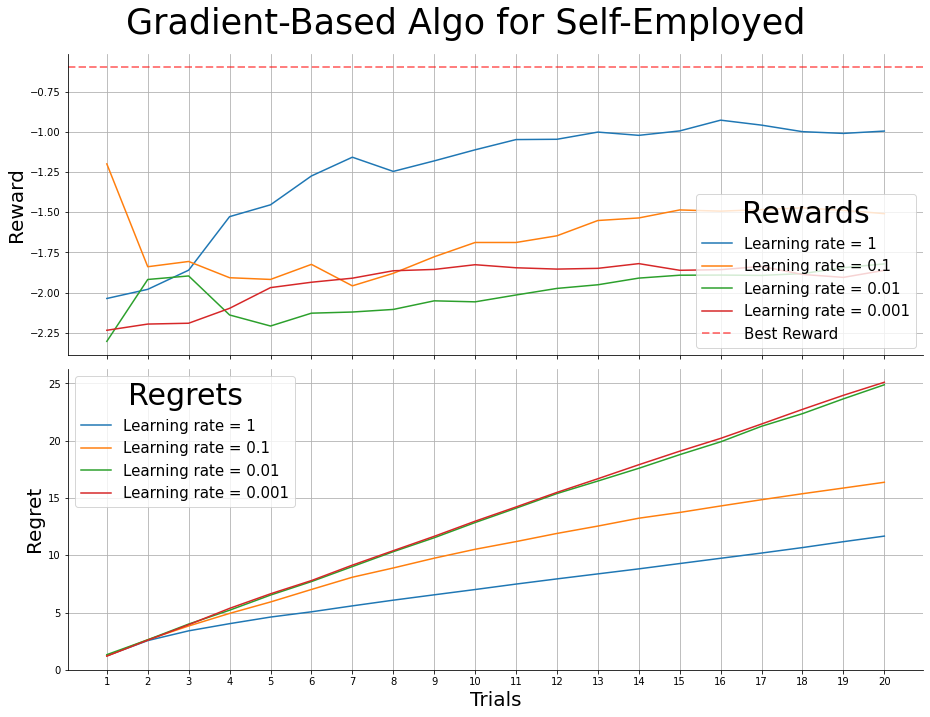

In [19]:
Gradient_Based_plots(run=500, trial=20, enviroment=SelfEmp, env_str='Self-Employed', LRs=[1, 0.1, 0.01, 0.001])

---
---